In [13]:
from xml.etree.ElementTree import PI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import os
import random
import seaborn as sns
import csv
import collections
from keras.preprocessing.image import load_img
from matplotlib.pyplot import figure
from tensorflow.python.client import device_lib
#from tensorflow.keras.utils import to_categorical
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras import backend as K

print(device_lib.list_local_devices())
warnings.filterwarnings('ignore')

mypath = "C:/Users/sager/OneDrive/Desktop/CS5824/Project/Models/cat_dog_classifier/cat_dog_classifier/kagglecatsanddogs_3367a/petfinder-pawpularity-score"
files = [os.path.splitext(filename)[0] for filename in os.listdir(mypath + "/train")]
#print(files)

filetr = open(mypath + "/train.csv")
csvreadertr = csv.reader(filetr)

tr_data = []
for row in csvreadertr:
    tr_data.append((row[0], row[13]))
del tr_data[0]

assert(collections.Counter(list(zip(*tr_data))[0]) == collections.Counter(files))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4728170868456128767
xla_global_id: -1
]


In [14]:
df = pd.DataFrame()
df['images'] = files
df['label'] = list(zip(*tr_data))[1]
df['label'] = df['label'].astype(int)
#df = df.sample(frac=1).reset_index(drop=True)
#df.head()
#print(df)

#testlabs = to_categorical(df['label'])
#print(np.sum(np.array(testlabs)))
#print(testlabs)

[22, 59, 77, 27, 41, 53, 10, 45, 3, 50, 35, 30, 25, 4, 17, 31, 28, 18, 32, 23, 28, 59, 33, 33, 28]


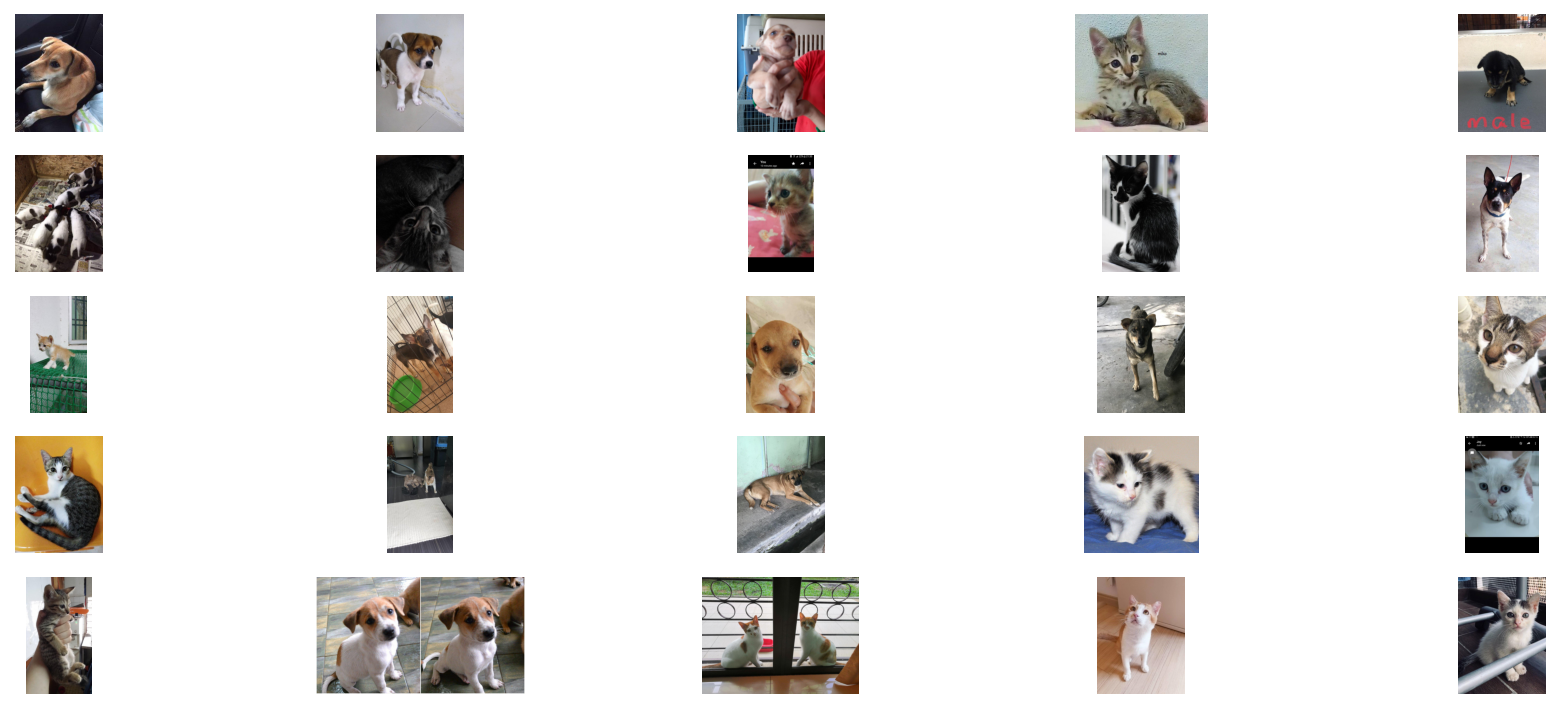

In [15]:
# Exploratory Data Analysis (dogs)
figure(figsize = (15, 6), dpi = 150)
#plt.figure(figsize=(10,7)) # display grid of images
temp = df['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

#TODO: figure out how to put ratings beneath each image
ratings = []
for index,file in enumerate(files):    
    plt.subplot(5,5,index+1)
    img = load_img(mypath + "/train/" + file + ".jpg")
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')
    ratings.append(np.array(df['label'][df['images'] == file])[0])

print(ratings)

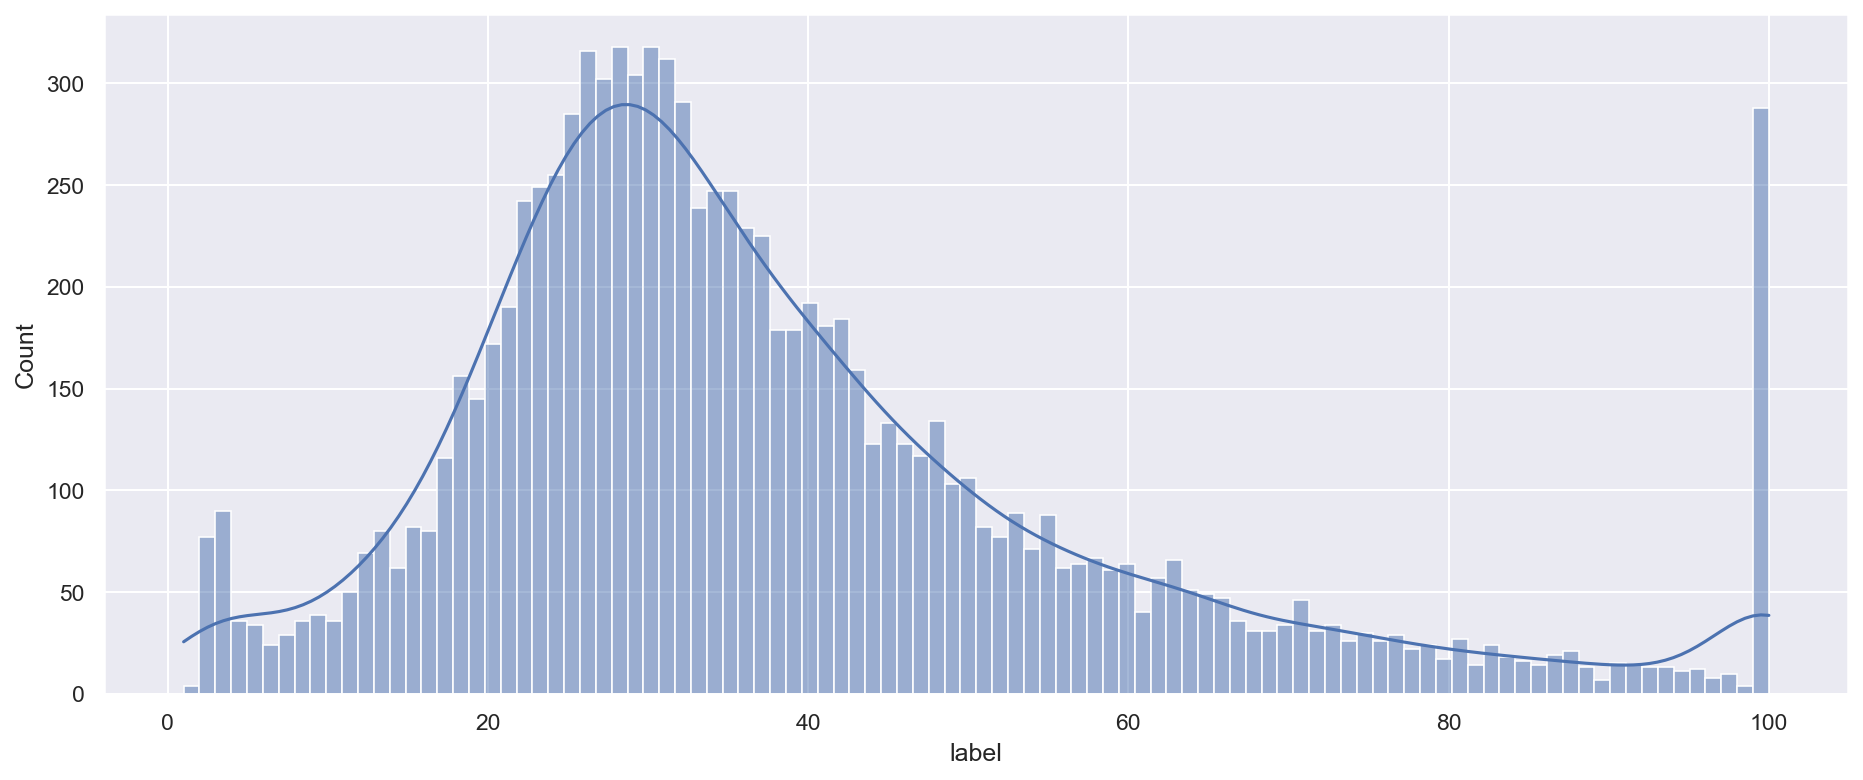

In [16]:
# show the total count for each of the labels
figure(figsize = (15, 6), dpi = 150)
sns.set(style="darkgrid")
ax = sns.histplot(df, x = 'label', bins = 100, kde = True)
plt.show()

In [17]:
print(df[(df['label'] < 100)]['label'])

0       63
1       42
2       28
3       15
4       72
        ..
9907    15
9908    70
9909    20
9910    20
9911    30
Name: label, Length: 9624, dtype: int32


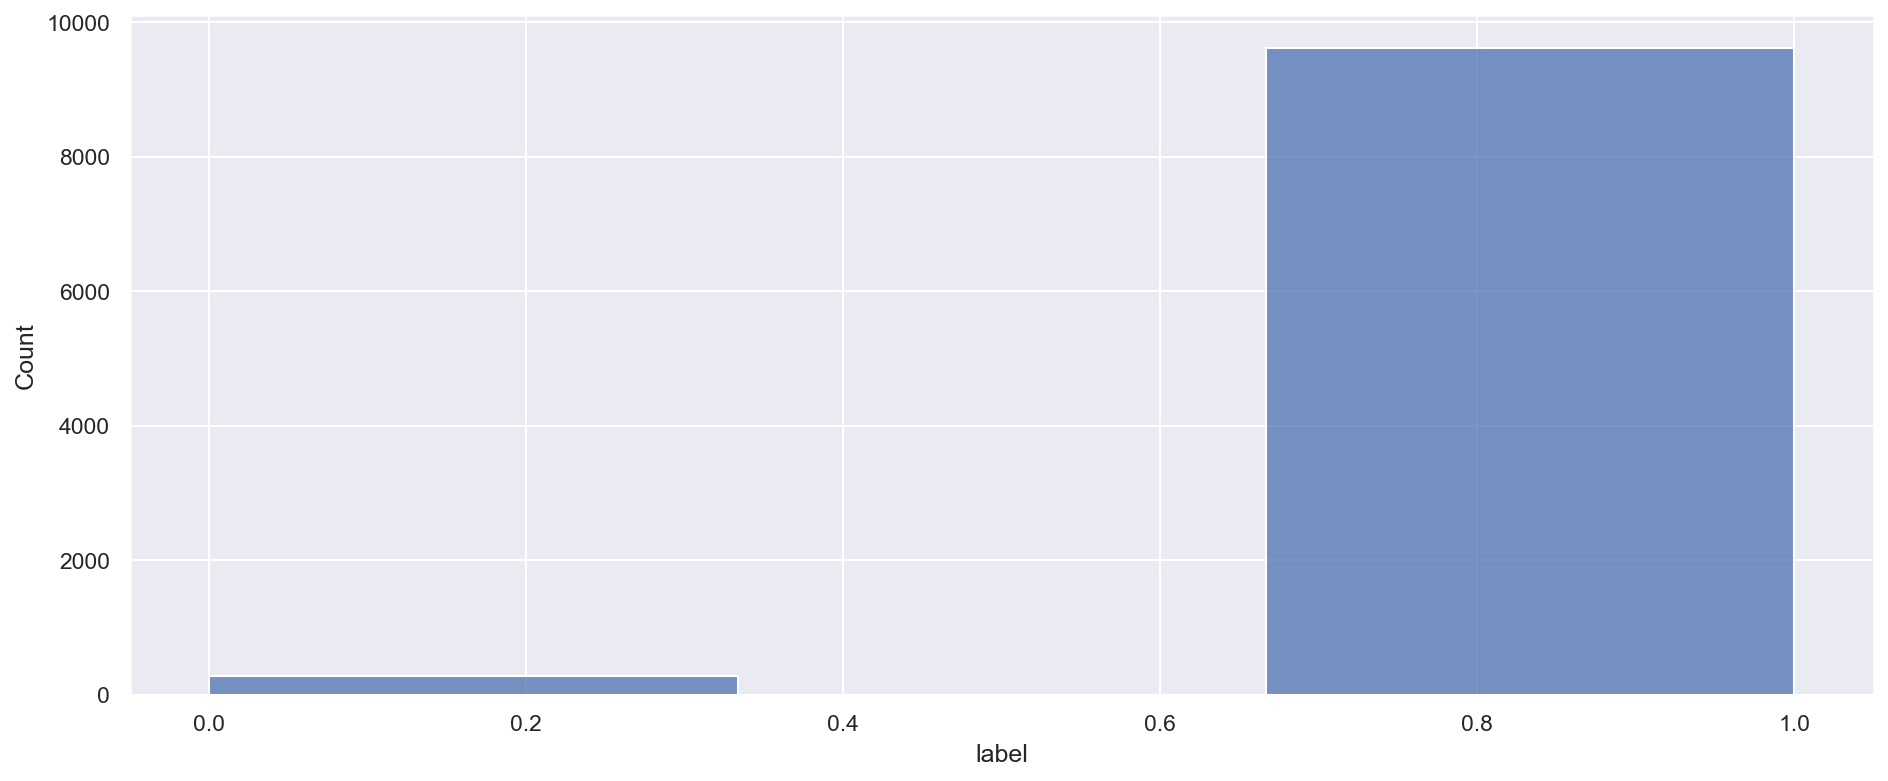

In [18]:
df.loc[df.label < 100, "label"] = 1
df.loc[df.label == 100, "label"] = 0
figure(figsize = (15, 6), dpi = 150)
sns.set(style="darkgrid")
ax = sns.histplot(df, x = 'label', bins = 3, kde = False)
plt.show()

In [19]:
print(df[df['label'] == 0])
print(df[df['label'] == 1])

                                images  label
19    00768659c1c90409f81dcdecbd270513      0
50    013f86ed0e765b189990d3d5ac28bd7d      0
86    0254f54b148543442373d5aad45b2d1a      0
182   04fef9f129bc6e4b90644d4290fde8c3      0
227   063d79b149f4d163eae86f777a39a42f      0
...                                ...    ...
9684  fa27d0eeeec835a00853d382f8777b19      0
9725  fb1b85c23f5cc8a079387ff575b67b50      0
9836  fde75ba22f491d31c9267e59f6cbfe1a      0
9843  fe200aff478f55ca4bcf77d9dade1217      0
9878  fedb56afb73e703dbcad66406943b45f      0

[288 rows x 2 columns]
                                images  label
0     0007de18844b0dbbb5e1f607da0606e0      1
1     0009c66b9439883ba2750fb825e1d7db      1
2     0013fd999caf9a3efe1352ca1b0d937e      1
3     0018df346ac9c1d8413cfcc888ca8246      1
4     001dc955e10590d3ca4673f034feeef2      1
...                                ...    ...
9907  ffbfa0383c34dc513c95560d6e1fdb57      1
9908  ffcc8532d76436fc79e50eb2e5238e45      1
9909  ffdf

In [20]:
df['images'] = mypath + "/train/" + df['images'] + ".jpg" 
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=11)
#print(train.iloc[0][0])
#print(test['images'])

In [21]:
df['label'] = df['label'].astype('str')
train['label'] = train['label'].astype('str')
test['label'] = test['label'].astype('str')

In [22]:
print(train['label'])

9900    1
117     1
7672    1
5522    1
1218    1
       ..
1293    1
4023    1
7259    1
5200    1
3775    1
Name: label, Length: 7929, dtype: object


In [23]:
# Create data generator for the images
# splitting into testing and training data
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255, # normalize the image 
    rotation_range = 360, # augmentation of images (helps to avoid overfitting)
    width_shift_range=0.35,
    height_shift_range=0.35,
    shear_range = 0.35,
    zoom_range = 0.35,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
)

val_generator = ImageDataGenerator(rescale=1./255)

# TODO: can't seem to find documentation on what target_size does under hood
train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=64, 
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=64, 
    class_mode='binary'
)

Found 7929 validated image filenames belonging to 2 classes.
Found 1983 validated image filenames belonging to 2 classes.



model2 = Sequential([
    Conv2D(64, (7,7), activation='relu', input_shape=(128,128,3)),
    MaxPool2D((3,3)),
    Conv2D(16, (5,5), activation='relu'),
    MaxPool2D((3,3)),
    Conv2D(16, (4,4), activation='relu'),
    Conv2D(16, (2,2), activation='relu'),
    #Conv2D(256, (2,2), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dropout(rate = 0.25),    
    Dense(2048, activation='sigmoid'),    
    Dense(1, activation='linear'),
])

In [24]:
from keras.layers.advanced_activations import PReLU
from keras import regularizers
model = Sequential([
    Conv2D(128, (12,12), activation=PReLU(), input_shape=(128,128,3)),
    MaxPool2D((3,3)),
    Conv2D(256, (8,8), activation=PReLU()),
    MaxPool2D((3,3)),
    Conv2D(512, (5,5), activation=PReLU()),
    MaxPool2D((2,2)),
    Conv2D(1024, (2,2), activation=PReLU()),
    #Conv2D(2048, (2,2), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dropout(rate = 0.5),    
    Dense(4096, activation=PReLU()),    
    Dropout(rate = 0.5),    
    Dense(1048, activation=PReLU()),    
    Dropout(rate = 0.5),    
    Dense(1, kernel_regularizer = regularizers.l2(0.01), activation= "softmax")
    #Dense(1,activation='sigmoid')
])

#model.add(Dense(number_of_classes,kernel_regularizers = l2(0.01),activation= "softmax"))
model.compile(optimizer="adam",loss="squared_hinge", metrics = ['accuracy'])

import tensorflow as tf
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall() ])
model.summary()

#K.set_value(model.optimizer.learning_rate, 0.1)
#model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 117, 117, 128)     1807616   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 39, 39, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       2359552   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 512)         3295744   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 3, 3, 512)        0

In [25]:
history = model.fit(train_iterator, epochs=5, validation_data=val_iterator, shuffle=True)

Epoch 1/5
124/124 [==============================] - 635s 5s/step - loss: 0.1230 - accuracy: 0.9701 - val_loss: 0.1029 - val_accuracy: 0.9743
Epoch 2/5
124/124 [==============================] - 616s 5s/step - loss: 0.1196 - accuracy: 0.9701 - val_loss: 0.1029 - val_accuracy: 0.9743
Epoch 3/5
 93/124 [=====================>........] - ETA: 2:28 - loss: 0.1191 - accuracy: 0.9702

KeyboardInterrupt: 

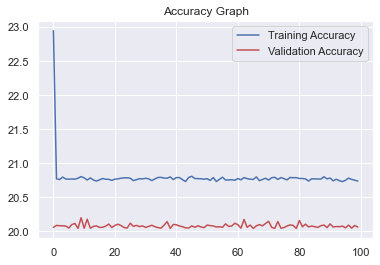

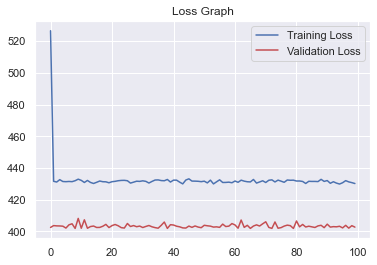

[20.060747146606445, 20.08926010131836, 20.084924697875977, 20.083688735961914, 20.080238342285156, 20.0505313873291, 20.1016845703125, 20.117860794067383, 20.045063018798828, 20.202205657958984, 20.04792594909668, 20.180246353149414, 20.047679901123047, 20.074514389038086, 20.082454681396484, 20.059768676757812, 20.060958862304688, 20.07912826538086, 20.10851287841797, 20.058521270751953, 20.08940887451172, 20.106637954711914, 20.086910247802734, 20.05729866027832, 20.050907135009766, 20.12236976623535, 20.074844360351562, 20.089916229248047, 20.07176399230957, 20.081924438476562, 20.05911636352539, 20.0761775970459, 20.09112548828125, 20.07052230834961, 20.057662963867188, 20.0485782623291, 20.09347915649414, 20.145305633544922, 20.045207977294922, 20.103551864624023, 20.098377227783203, 20.079824447631836, 20.070180892944336, 20.05341339111328, 20.050748825073242, 20.082021713256836, 20.061843872070312, 20.083650588989258, 20.066499710083008, 20.05647087097168, 20.09429931640625, 20

In [ ]:
# Visualization of Results
accuracy = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


print(val_acc)

In [ ]:
# save model and outputs
#np.savetxt('data.csv', (accuracy, val_acc, loss, val_loss), delimiter=',')
#model.save('seventeen_hr.h5')